In [1]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/nicholasbright/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nicholasbright/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nicholasbright/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

ImportError: cannot import name 'export_saved_model' from 'tensorflow.python.keras.saving.saved_model' (/Users/nicholasbright/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/__init__.py)

In [3]:
data = pd.read_csv('cap3_data.csv')

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)
data['UTC Time at End of Hour'] = pd.to_datetime(data['UTC Time at End of Hour'], errors='raise')

In [19]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3156438 entries, 2015-07-01 06:00:00 to 2021-01-01 05:00:00
Data columns (total 13 columns):
 #   Column                                                  Non-Null Count    Dtype  
---  ------                                                  --------------    -----  
 0   Balancing Authority                                     3156438 non-null  object 
 1   Demand Forecast (MW)                                    745868 non-null   float64
 2   Demand (MW)                                             3156438 non-null  float64
 3   Net Generation (MW)                                     1278726 non-null  float64
 4   Total Interchange (MW)                                  2342764 non-null  float64
 5   Net Generation (MW) from Coal                           2198539 non-null  float64
 6   Net Generation (MW) from Natural Gas                    2382768 non-null  float64
 7   Net Generation (MW) from Nuclear                        1808818 no

In [9]:
data.head()

,Balancing Authority,Demand Forecast (MW),Demand (MW),Net Generation (MW),Total Interchange (MW),Net Generation (MW) from Coal,Net Generation (MW) from Natural Gas,Net Generation (MW) from Nuclear,Net Generation (MW) from All Petroleum Products,Net Generation (MW) from Hydropower and Pumped Storage,Net Generation (MW) from Solar,Net Generation (MW) from Wind,Net Generation (MW) from Other Fuel Sources
UTC Time at End of Hour,,,,,,,,,,,,,
2015-07-01 06:00:00,AEC,882.0,422.0,670.0,248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 07:00:00,AEC,819.0,395.0,620.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 08:00:00,AEC,782.0,382.0,637.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 09:00:00,AEC,763.0,370.0,619.0,249.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 10:00:00,AEC,774.0,383.0,633.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#data = data.set_index('UTC Time at End of Hour')
data['Demand (MW)'] = data['Demand (MW)'].fillna(0)

In [29]:
demand = data['Demand (MW)']

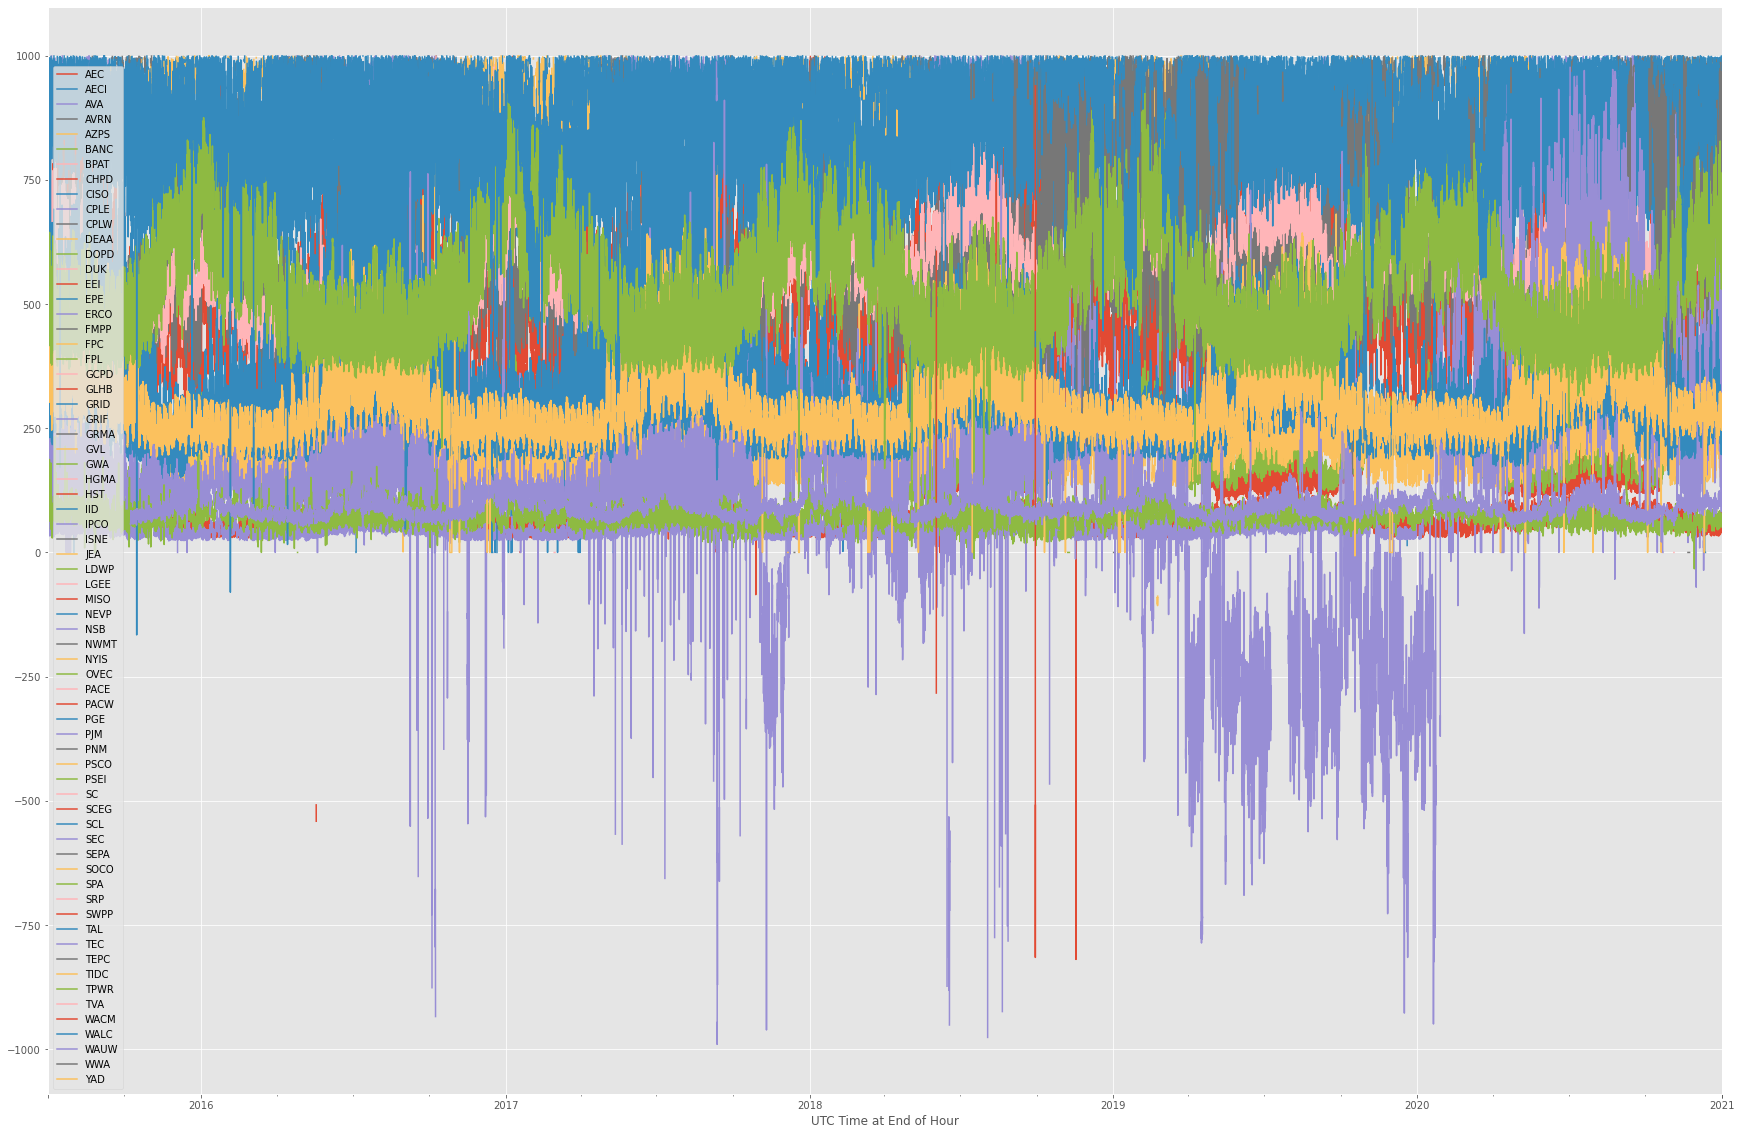

In [42]:
ax = data['Demand (MW)'].groupby(data['Balancing Authority']).plot(figsize=(30, 20), legend=True)

In [30]:
a = seasonal_decompose(demand, model='add')
a.plot()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [21]:
a.seasonal.plot()

In [ ]:
auto_arima(data['Demand (MW)'], 
           seasonal=True, 
           m=12, 
           max_p=7, 
           max_d=5, 
           max_q=7, 
           max_P=4, 
           max_D=4, 
           max_Q=4).summary()

In [ ]:
train_data = data[:len(data)-12]
test_data = data[len(data)-12:]

In [23]:
arima_model = SARIMAX(train_data['Demand (MW)'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

In [32]:
arima_pred = arima_result.predict(
    start = len(train_data), 
    end = len(df)-1, typ="levels").rename("ARIMA Predictions")

In [31]:
arima_pred

In [24]:
arima_rmse_error = rmse(test_data['Demand (MW)'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = data['Demand (MW)'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

In [25]:
test_data['ARIMA_Predictions'] = arima_pred

In [36]:
scaler = MinMaxScaler()

In [26]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [10]:
train_data = data[:len(data)-12]
test_data = data[len(data)-12:]

LSTM Model

In [27]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train_data, 
                                scaled_train_data, 
                                length=n_input, batch_size=1)

In [41]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

SyntaxError: positional argument follows keyword argument (<ipython-input-41-12b55e9bcdfc>, line 2)

In [ ]:
lstm_model.fit_generator(generator, epochs=10)

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

In [ ]:
for i in range(len(test_data)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)

In [ ]:
lstm_predictions_scaled

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

In [ ]:
test_data['Demand (MW)'].plot(figsize=(16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend=True)

In [ ]:
lstm_rmse_error = rmse(test_data['Demand (MW)'],
                      test_data['LSTM_Predictions'])
lstm_mst_error = lstm_rmse_error**2
mean_value = data['Demand (MW)'].mean()

print(f'MSE Error: {lstm_mse_error}\n
RMSE Error:{lstm_rmse_error}\
nMean: {mean_value})